<a href="https://colab.research.google.com/github/nah16d/Deep-Learning-in-Malaria-and-Covid-Detection/blob/main/Malaria/500epochs_malaria_2_inceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jan 11 20:04:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] 

In [ ]:
# training config:
epochs = 500
batch_size = 32

In [ ]:
#define paths
parasite_path = '/content/drive/MyDrive/cell_images_3/Parasite'
uninfected_path = '/content/drive/MyDrive/cell_images_3/Uninfected'

In [ ]:
# Use glob to grab images from path .jpg or jpeg
parasite_files = glob(parasite_path + '/*')
uninfected_files = glob(uninfected_path + '/*')

In [ ]:
# Visualize file variable contents
print("Total Count: ",len(parasite_files))
print("Total Count: ",len(uninfected_files))

Total Count:  321
Total Count:  214


In [ ]:
# Fetch Images and Class Labels from Files
parasite_labels = []
uninfected_labels = []

parasite_images=[]
uninfected_images=[]

for i in range(len(parasite_files)):
  image = cv2.imread(parasite_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per kera
  image = cv2.resize(image,(224,224)) # resize as per model
  parasite_images.append(image) # append image
  parasite_labels.append('parasite') # append class label
for i in range(len(uninfected_files)):
  image = cv2.imread(uninfected_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  uninfected_images.append(image)
  uninfected_labels.append('uninfected')

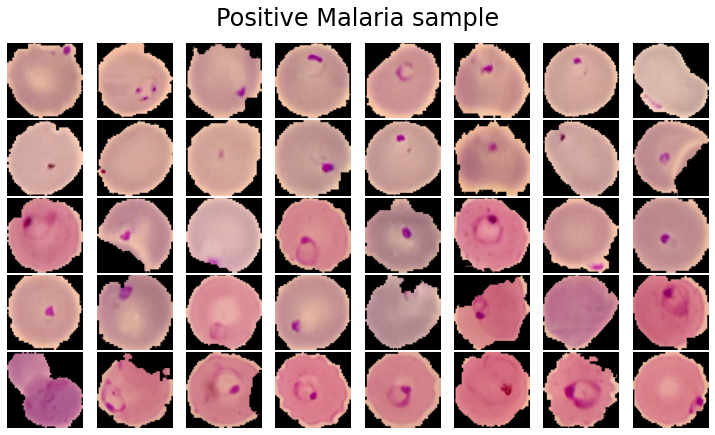

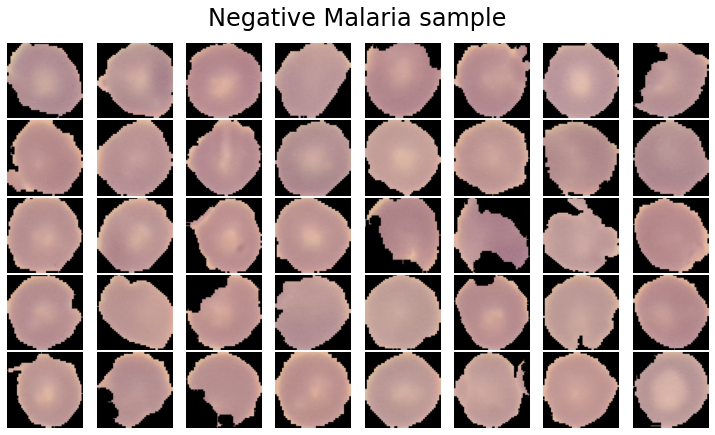

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(parasite_images, 'Positive Malaria sample')
plot_images(uninfected_images, 'Negative Malaria sample')

In [ ]:
# Convert to array and Normalize to interval of [0,1]
parasite_images = np.array(parasite_images) / 255
uninfected_images = np.array(uninfected_images) / 255

In [ ]:
# split into training and testing
parasite_x_train, parasite_x_test, parasite_y_train, parasite_y_test = train_test_split(
    parasite_images, parasite_labels, test_size=0.2)
uninfected_x_train, uninfected_x_test, uninfected_y_train, uninfected_y_test = train_test_split(
    uninfected_images, uninfected_labels, test_size=0.2)


X_train = np.concatenate((uninfected_x_train, parasite_x_train), axis=0)
X_test = np.concatenate((uninfected_x_test, parasite_x_test), axis=0)
y_train = np.concatenate((uninfected_y_train, parasite_y_train), axis=0)
y_test = np.concatenate((uninfected_y_test, parasite_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

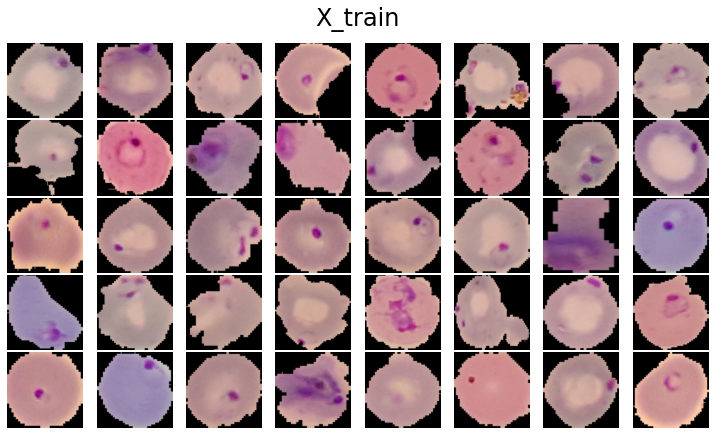

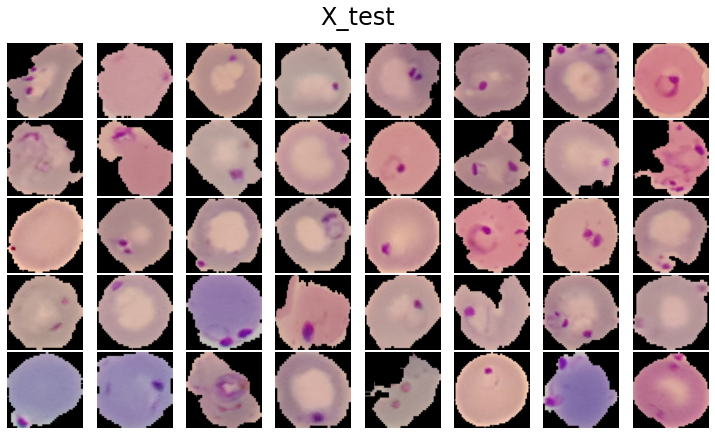

In [ ]:
plot_images(parasite_x_train, 'X_train')
plot_images(parasite_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing parasite and uninfected for X_train and X_test

In [ ]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
# Visualize Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
13/13 [==============================] - 17s 511ms/step - loss: 3.3856 - accuracy: 0.6639 - val_loss: 0.5195 - val_accuracy: 0.9259
Epoch 2/500
13/13 [==============================] - 5s 350ms/step - loss: 1.0034 - accuracy: 0.8811 - val_loss: 0.4737 - val_accuracy: 0.9352
Epoch 3/500
13/13 [==============================] - 5s 347ms/step - loss: 0.5856 - accuracy: 0.9036 - val_loss: 0.3527 - val_accuracy: 0.9444
Epoch 4/500
13/13 [==============================] - 5s 346ms/step - loss: 0.4531 - accuracy: 0.9244 - val_loss: 0.3558 - val_accuracy: 0.9537
Epoch 5/500
13/13 [==============================] - 5s 350ms/step - loss: 0.3647 - accuracy: 0.9479 - val_loss: 0.3701 - val_accuracy: 0.9537
Epoch 6/500
13/13 [==============================] - 5s 354ms/step - loss: 0.6936 - accuracy: 0.9058 - val_loss: 0.2781 - val_accuracy: 0.9537
Epoch 7/500
13/13 [==============================] - 5s 348ms/step - loss: 0.4649 - accuracy: 0.9315 - val_loss: 0.3480 - val_accuracy: 0.935

In [ ]:
# Save Model and Weights
model.save('500epochs_malaria_2.h5')
model.save_weights('500epochs_malaria_2_weights.hdf5')

In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.keras.models.save_model(model, '/content/drive/MyDrive/cell_images_3/inceptionmodel')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/cell_images_3/inceptionmodel/assets


In [ ]:
# Load saved model
model = load_model('/content/drive/MyDrive/cell_images_3/inceptionmodel')

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

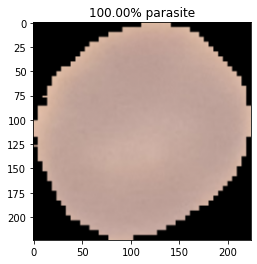

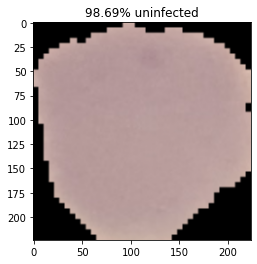

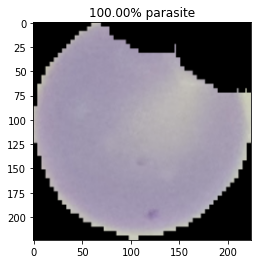

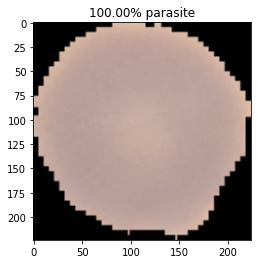

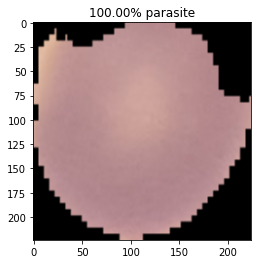

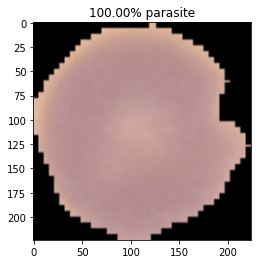

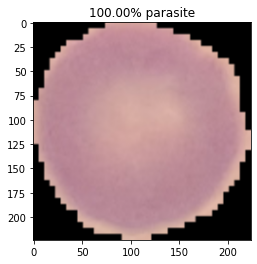

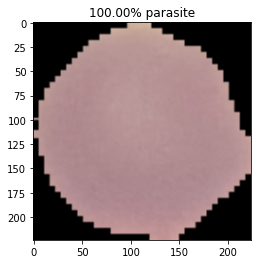

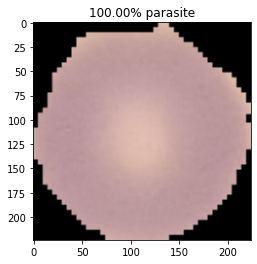

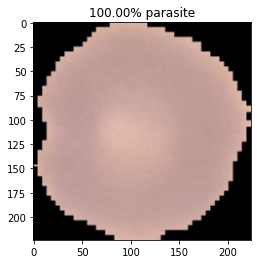

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% parasite')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% uninfected')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

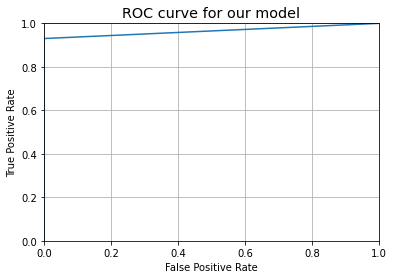

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


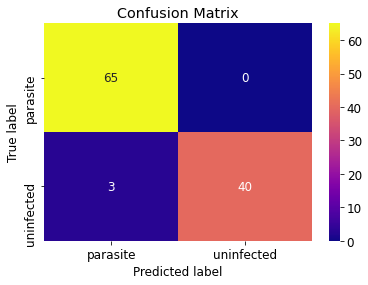

Confusion Matrix with Normalized Values


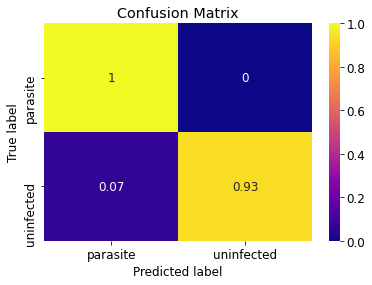

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['parasite','uninfected']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        65
           1       1.00      0.93      0.96        43

    accuracy                           0.97       108
   macro avg       0.98      0.97      0.97       108
weighted avg       0.97      0.97      0.97       108



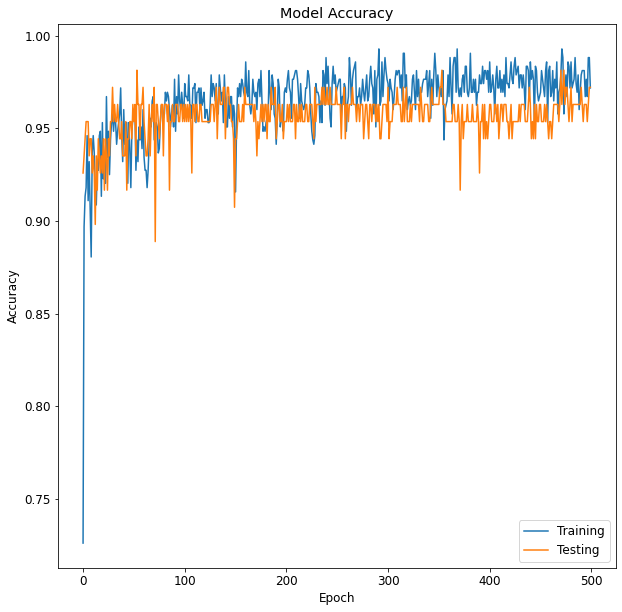

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('500epochs_inception_accuracy.png')
plt.show()


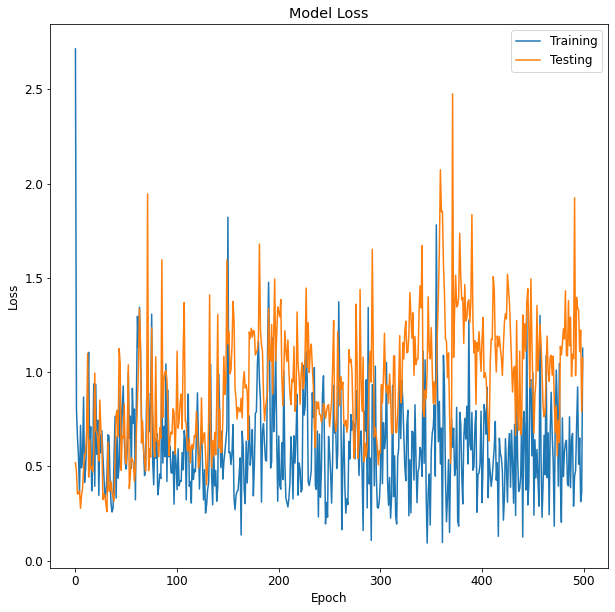

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('500epochs_inception_loss.png')
plt.show()

In [ ]:
#ACCURACY
from sklearn.metrics import accuracy_score
print('Accuracy score:' , accuracy_score(y_test_bin, y_pred_bin))

Accuracy score: 0.9722222222222222


In [ ]:
# Load saved model
model = load_model('/content/drive/MyDrive/Malaria Detection/malaria_2.hdf5')

In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.keras.models.save_model(model, '/content/drive/MyDrive/Malaria Detection/malaria_2.hdf5')